# Contextual Bandits

A minimalist notebook to experiement with contextual bandit environments and agents.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from scipy.stats import invgamma, gamma
from scipy.stats import t as student

In [2]:
np.set_printoptions(precision=2)

In [3]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def logit(p):
    return np.log(p/(1-p))

## Environment
The contextual Multi-Armed Bandit setting is as follow: 

At each step we observe a vector of features for each arm and chose to pull one. We then recieve a reward and observe the features for the next round.

In [4]:
class CMAB:
    """ 
    Contextual Multi-Armed Bandit environment with Bernoulli or Gaussian rewards.
    """
    def __init__(self, nb_arms, context_size, coef=None, bernoulli=True, seed=None):
        """ mean_reward_a = coef_{0,a} + \sum_{j,a} x_{j,a}*beta_{j,a} """
        self._nb_arms = nb_arms
        self._p = context_size
        self._bernoulli = bernoulli
        self._rng = np.random.RandomState(seed)
        
        if coef is not None:
            assert coef.shape == (self._nb_arms, self._p + 1,)
            self._beta = coef
        else:
            self._beta = self._rng.uniform(size=(self._nb_arms, self._p + 1))
    
    def step(self, action):
        """ Play an action """
        self._mean_reward = np.einsum('ij,ij->i', self._context, self._beta)
        
        
        if self._bernoulli:
            self._mean_reward = sigmoid(self._mean_reward)
            reward = self._rng.binomial(p=self._mean_reward[action], n=1, size=1)[0]
        else:
            reward = self._rng.normal(loc=self._mean_reward[action], scale=0.1, size=1)[0]
        
        optimal_return = np.max(self._mean_reward)
        
        self._context = self._rng.normal(size=(self._nb_arms, self._p + 1))
        self._context[:,0] = 1 # constant part, i.e for beta_0
        context = deepcopy(self._context)
        
        return reward, context, optimal_return
    
    def reset(self):
        self._context = self._rng.normal(size=(self._nb_arms, self._p + 1))
        self._context[:,0] = 1 # constant part, i.e for beta_0
        context = deepcopy(self._context)
        return context

### Example 1:
Let reproduce the previous example as this environment is a generalization of the simple MAB.

Set a Bernoulli Multi-Armed Bandit with reward probability of 
- 50% for arm A
- 20% for arm B
- 80% for arm C

Note that this time we should set the coef to the logit(p) to match the previous example.

In [5]:
env = CMAB(nb_arms=3, context_size=0, coef=logit(np.array([[.5], [.2], [.8]])), bernoulli=True, seed=2020)

We first need to reset the environment to get the initial context

In [6]:
context = env.reset()
context

array([[1.],
       [1.],
       [1.]])

The context is the same for all arms, i.e there is no context in this simple multi-armed bandit example.

Let's play arm C once:

In [7]:
reward, context, optimal_return = env.step(2)
reward

1

We get a reward of 1.

Let's now play arm A.

In [8]:
reward, context, optimal_return = env.step(0)
reward

0

We get no reward.

### Example 2:
Let assume we are facing three armed bandit that display a value on the screen.

Their mean reward is now:
\beta_0 + \beta_1*x

where x is the displayed value, or context and betas are constant that differ betwenn the bandits and are hiden to the agent. 

In [9]:
env = CMAB(nb_arms=3, context_size=1, coef=np.array([[.5, 1], [.2, -1], [.8, 0]]), bernoulli=False, seed=2020)

Once again, we should first reset the environment to get the initial context

In [10]:
context = env.reset()
context

array([[ 1.  ,  0.08],
       [ 1.  , -0.65],
       [ 1.  , -1.27]])

This mean that the value displayed by the first bandit is 0.08, 

-0.65 for the second one, etc

Let's play arm C once:

In [11]:
reward, context, optimal_return = env.step(2)
reward

0.7938845568046652

We get a reward of 0.79 and a new context

Let's now play arm A.

In [12]:
reward, context, optimal_return = env.step(0)
reward

0.7886771893126919

We get a reward of 0.78.

Now let's build an Agent that will play with our environment.

## Agent
Here we create a very basic agent that will pull arm, i.e.play action, at random.

In [13]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        action = self._rng.randint(self._nb_arms)
        return action
        
    def update(self, context, action, reward):
        pass


#### Example
Let's build an Agent and ask him to choose an action

In [14]:
agent = Random(nb_arms=3, seed=2020)
agent.act(context)

0

Here the agent choose to play arm A.

## Run experiment
In order to make Agent and Environment interract, we can create an experiment, parametrized by the number of step we will be running.

In [15]:
def run_exp(agent, env, nb_steps):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    context = env.reset()
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act(context)
        
        # Play action in the environment and get reward.
        reward, next_context, optimal_return = env.step(action)
        
        # Update agent.
        agent.update(context, action, reward)
        context = next_context
        
        # Save history.
        #context[i] = context
        rewards[i] = reward
        actions[i] = action
        regrets[i] = optimal_return - reward

    reward = rewards.sum()
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets)
            }


#### Example
Let's run our previous agent and environment 100 times.

In [16]:
run_exp(agent, env, nb_steps=100)

{'reward': 54.57278051522984,
 'regret': 63.90923197536222,
 'rewards': array([ 0.4 ,  0.77,  0.07, -1.26, -0.73, -0.04,  0.75,  0.47,  0.87,
        -0.79,  0.7 ,  0.78,  0.97, -0.26,  0.02,  1.74,  0.44, -0.66,
         0.66,  1.64,  1.09,  1.9 , -0.62,  0.76, -0.87,  0.83,  0.47,
         0.12,  0.56,  0.76,  0.73,  0.76, -1.19, -0.99,  0.93,  0.83,
         1.03,  0.72, -0.94,  1.62,  1.19,  1.  ,  0.74,  0.78,  0.97,
         1.84, -0.67,  0.83,  0.89,  1.  ,  1.08,  0.9 ,  1.09,  0.98,
         0.75, -1.46,  0.94, -0.19,  0.76,  0.85,  2.05, -1.34,  0.79,
         0.2 ,  0.77,  0.8 ,  0.85, -0.44,  0.6 ,  0.57,  0.14,  0.09,
        -0.35,  2.49,  1.83,  2.33,  1.  , -0.32, -0.85,  1.16,  0.83,
        -0.39,  1.62,  0.84, -0.43,  0.85,  0.7 ,  1.  ,  1.66, -0.61,
         1.45,  0.8 ,  1.66,  0.55,  0.96,  0.35,  0.69, -0.73,  0.81,
         0.28]),
 'regrets': array([ 3.99e-01,  1.13e-01,  7.30e-01,  2.83e+00,  1.53e+00,  8.43e-01,
         6.79e-01,  1.26e+00,  5.67e-01,  1.59

You can see that on this experiment the total reward is 54 and the regret is 63. You can also have a look at individual rewards, actions or regrets.

Due to stochasticity of both the environment and the agent, it's better to run multiple experiments.

## Multiple experiments

In order to get empirical confidence bound on those statistics we can run the experiment multiple time.

Hint: don't forget to change the seed. 

In [17]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = CMAB(nb_arms=3, context_size=1, coef=np.array([[.5, 1], [.2, -1], [.8, 0]]), 
               bernoulli=False, seed=i)
    agent = Random(env._nb_arms, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

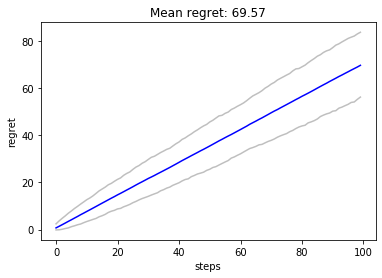

In [18]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

Here you can see the average regret over steps and the empirical 5% and 95% confidence intervall.

Note that the stochasticity is may comes from the agent and/or the environment.

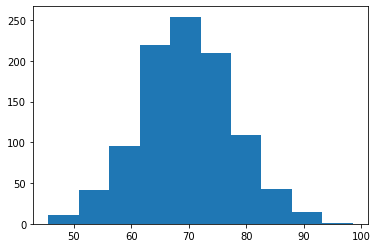

In [19]:
plt.hist(regret)
plt.show()

Here is the distribution of the total regret.

In this simple case you could compute it exactly by hand.

# Exercices:

1. Implement an epsilon-greedy agent.
2. Implement an UCB agent.
3. Implement a Thompson sampling agent.

## 1. Epsilon-greedy 

In [20]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [21]:
class EpsilonGreedy:
    """ Epsilon greedy agent. """
    def __init__(self, nb_arms, context_size, lr=.1, epsilon=0, seed=None):
        self._nb_arms = nb_arms
        self._p = context_size
        self._lr = lr
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._beta = np.zeros((nb_arms, self._p)) 
        self._n = np.zeros(nb_arms)
        self._pred_reward = np.zeros(nb_arms)
        
    def act(self, context):
        if self._rng.random() < self._epsilon:
            action = self._rng.randint(self._nb_arms)
        else:
            pred_reward = np.einsum('ij,ij->i', context, self._beta)
            action = random_argmax(self._rng, pred_reward)
        return action
        
    def update(self, context, action, reward):
        """ Simple gradient descent. """
        self._n[action] += 1
        grad = - context[action] * (reward - context[action].dot(self._beta[action]))
        self._beta[action] = self._beta[action] - self._lr/self._n[action] * grad
        

In [22]:
nb_exp = 1000
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = CMAB(nb_arms=3, context_size=1, coef=np.array([[.5, 1], [.2, -1], [.8, 0]]), 
               bernoulli=False, seed=i)
    agent = EpsilonGreedy(env._nb_arms, context_size=2, lr=1, epsilon=0.1, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

In [23]:
print('True beta: \n', env._beta)
print('Estimated beta on the last experiment: \n', agent._beta)

True beta: 
 [[ 0.5  1. ]
 [ 0.2 -1. ]
 [ 0.8  0. ]]
Estimated beta on the last experiment: 
 [[ 0.45  1.05]
 [ 0.4  -0.8 ]
 [ 0.71 -0.12]]


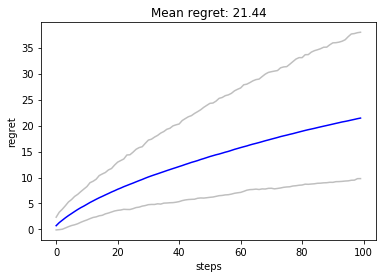

In [24]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## 3. Thompson sampling

Reference: 
- https://arxiv.org/abs/1802.09127
- https://en.wikipedia.org/wiki/Bayesian_linear_regression

Wishard distribution is a generalization to multiple dimensions of the gamma distribution.

In [25]:
class NormalInverseWishart(object):
    def __init__(self, p, sigma = .01, a=2, b=2):
        self._p = p         # numbe of dimension
        self._mean_0 = np.zeros(p) # vector of mean
        self._precision_0 = sigma * np.eye(self._p) 
        self._a_0 = a
        self._b_0 = b
        self._n = 0
        
        self._x = np.empty((0, self._p), float)
        self._y = np.empty((0, 1), float)

    def update(self, context, reward):
        self._n += 1
        
        # storing data
        self._x = np.append(self._x, context.reshape(1, self._p), axis=0)
        self._y = np.append(self._y, reward.reshape(1,1), axis=0)

        s = np.dot(self._x.T, self._x)
        new_precision = self._precision_0 + s  
        cov = np.linalg.inv(new_precision)
        
        new_mean = np.dot(cov, np.dot(self._precision_0, self._mean_0) + (np.dot(self._x.T, self._y)).flatten())
        self._a = self._a_0 + self._n/2.
        self._b = self._b_0 + 0.5 * (  np.dot(np.transpose(self._y), self._y) 
                                     + np.dot(self._mean_0.T, np.dot(self._precision_0, self._mean_0)) 
                                     - np.dot(new_mean.T, np.dot(new_precision, new_mean)))
               
        self._mean = new_mean
        self._precision = new_precision
        
        # exercice: implement an online version

    def sample(self, context, np_random):
        if self._n <= 2:
            return np.Inf
        else:           
            sigma = self._b * invgamma.rvs(self._a)
            beta = np.random.multivariate_normal(self._mean, sigma * self._precision**-1)
            return beta.dot(context)
        
class Thompson_sampling:
    """ Thompson sampling agent. """
    def __init__(self, nb_arms, p, dist=NormalInverseWishart, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        self._posterior = [dist(p) for i in range(self._nb_arms)]
        
    def act(self, context):
        sample = np.array([self._posterior[i].sample(context[i], self._rng)
                           for i in range(self._nb_arms)])
        action = np.argmax(sample)
        return action
        
    def update(self, context, action, reward):
        self._posterior[action].update(context[action], reward)

/Users/thibaultallart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: covariance is not positive-semidefinite.


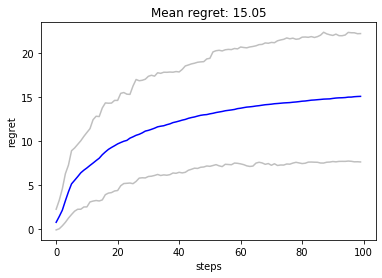

In [26]:
nb_exp = 100
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = CMAB(nb_arms=3, context_size=1, coef=np.array([[.5, 1], [.2, -1], [.8, 0]]), 
               bernoulli=False, seed=i)
    agent = Thompson_sampling(env._nb_arms, p=2, dist=NormalInverseWishart, seed=i)
    exp = run_exp(agent, env, nb_steps)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()